# Проект - Основы машинного обучения

**Описание**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

**Задачи**

- выделить целевые группы клиентов;
- предложить меры по снижению оттока;
- определить другие особенности взаимодействия с клиентами.

**В ходе исследования предстоит:**

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

**Описание данных**

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.


## Чтение  данных и изучение общей информации

In [2]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from itertools import combinations
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
display(df.head()) #получение первых 5 строк таблицы df
print()
display(df.info()) #получение общей информации о данных в таблице df
print()
df.duplicated().sum() #проверяем дубликаты

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   floa

None

0

После первого ознакомленния с данными видим, что информация предоставлена корректно, в полном объеме без пропусков и дубликатов. Типы даных также в нужном нам формате.

## Исследовательский анализ данных (EDA)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


По описанию данных видим, что процент оттока клиентов составляет почти 27%. Средний возраст клиентов 29 лет, также обратим внимание, что большинство посетителей живет близко к фитнес-центру. Почти у всех внесен контактный номер телефона, 48% клиентов являются сотрудниками партнерских компаний. Можем отметить, что время с момента первого обращения в фитнес-центр в среднем составляет 3,7 месяца. 

Далее посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [6]:
df.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


Можем предположить, что в отток попадают клиенты, которые живут несколько дальше от фитнес-центра, как правило они не являются сотрудниками партнерских компаний, реже посещают групповые занятия. В среднем попадающие в отток клиенты занимаются месяц, скореее всего  абонемент они приобретали на пробу, но их что-то не усроило и они нашли вариант фитнес-центра получше. 

Построим столбчатые гистограммы и распредения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

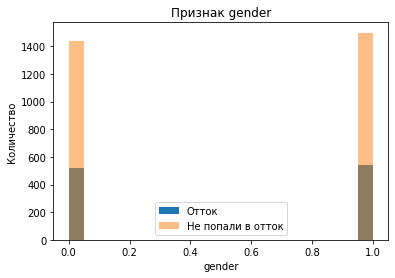

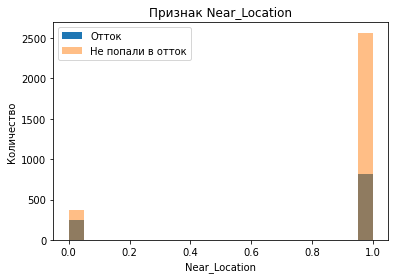

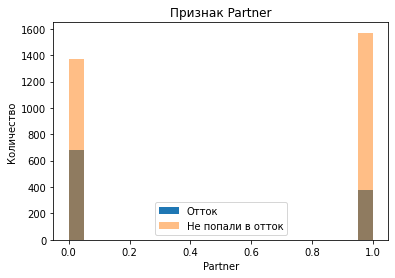

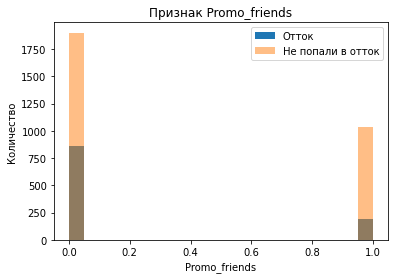

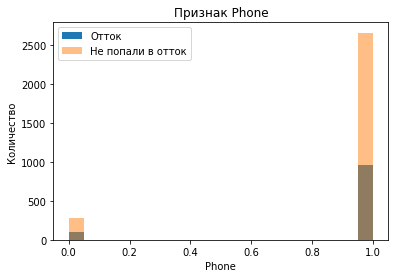

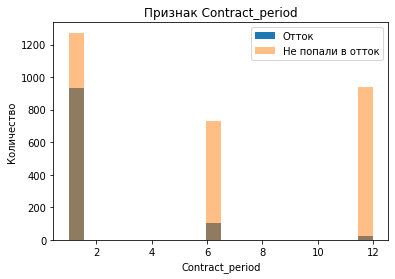

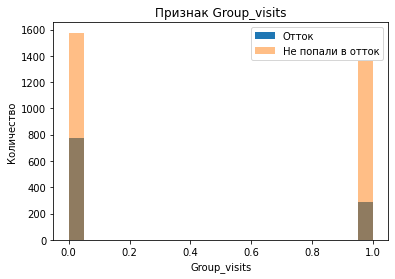

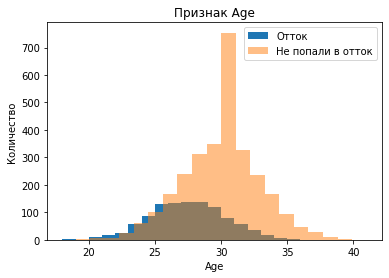

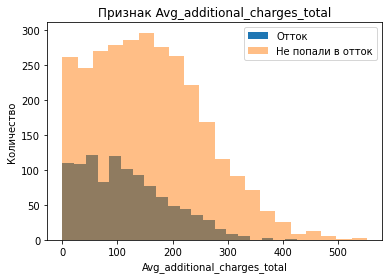

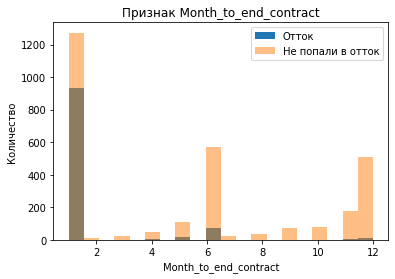

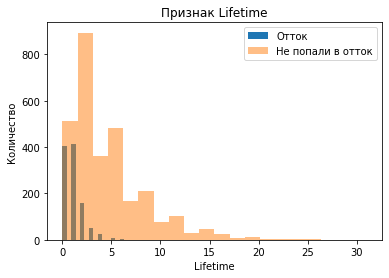

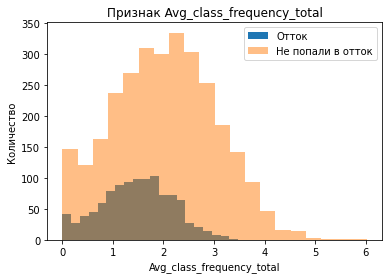

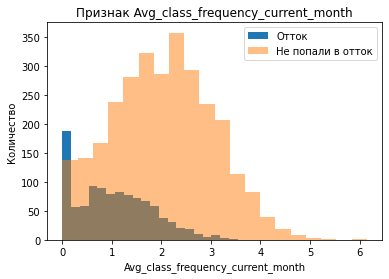

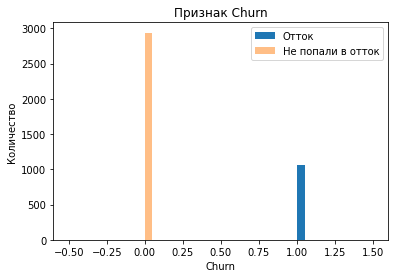

In [6]:
churn_1 = df.query('Churn==1')
churn_0 = df.query('Churn==0')
for j in df:
    plt.title('Признак '+j)
    plt.xlabel(j)
    plt.hist(churn_1[j], bins=20, alpha = 1, label = 'Отток')
    plt.hist(churn_0[j], bins=20, alpha = 0.50, label = 'Не попали в отток')
    plt.ylabel('Количество')
    plt.legend()
    plt.show()

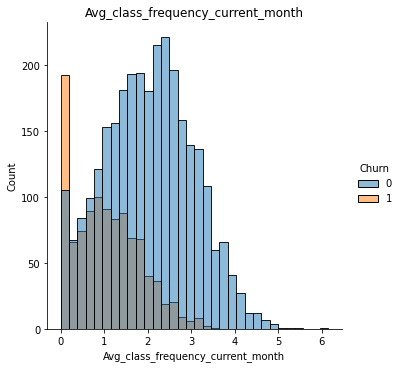

In [27]:
### CODE FROM REVIEWER

sns.displot(df, x='Avg_class_frequency_current_month', hue='Churn')
plt.title('Avg_class_frequency_current_month')
plt.show()

По графикам можем сделать вывод, что попадают в отток в основном клиенты, которые приобретают абонемент на 1 месяц. Также следует обратить внимание на параметр `Avg_additional_charges_total`— суммарная выручка от других услуг фитнес-центра, видим, что распределение смещено в лево, причем для оттока несколько больше. Скорее всего клиенты, которые попали в отток не приобретали никаких дополнительных услуг.

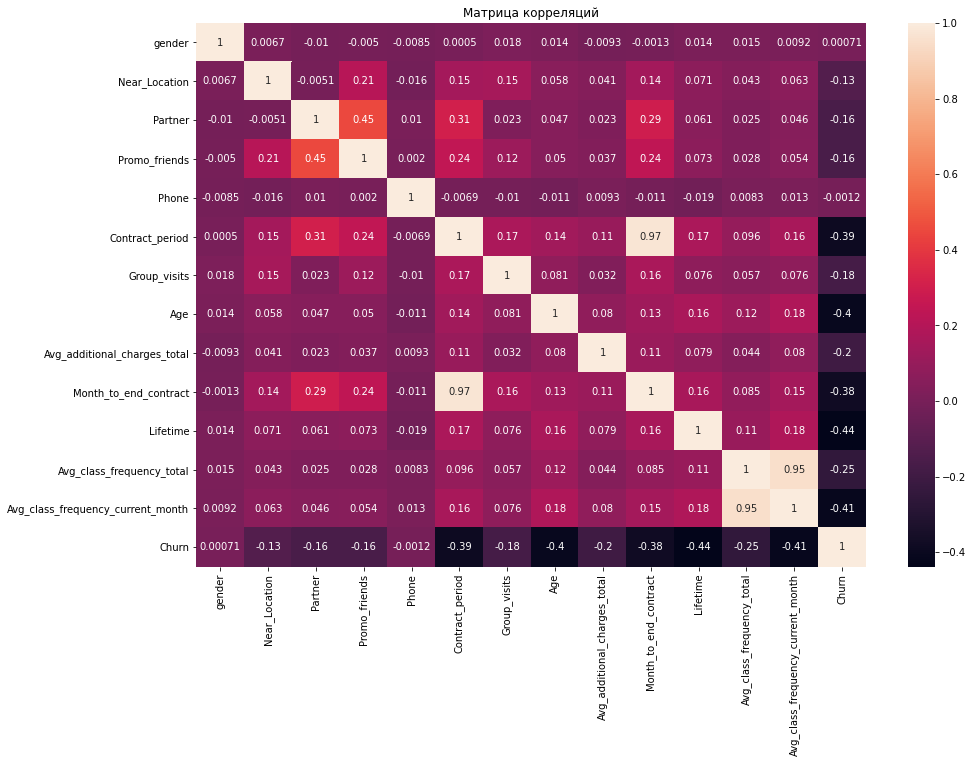

In [7]:
cr = df.corr() #построим матрицу корреляций

plt.figure(figsize=(15, 10))
#рисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cr, annot = True)
plt.title('Матрица корреляций')
plt.show()

По матрице корреляций мы выявили мультиколлинеарные признаки - это `Contract_period` и `Month_to_end_contact`, `Avg_class_frequency_total` и `Avg_class_frequency_current_month`. 
Чтобы в дальнейшем не возникли проблемы с линейной регрессией для каждой пары сильно скоррелированных признаков удалим один из них вручную.

In [8]:
df = df.drop(['Month_to_end_contract', 'Avg_class_frequency_total'], axis=1)

## Строим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [9]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

In [10]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [11]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test)

# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.79


In [12]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели случайного леса:',
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.80


На основании полученных метрик нам больше подойдет модель логистической регрессии, так как доля правильных прогнозов несколько выше, чем у модели случайного леса.

## Кластеризация клиентов

In [13]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X)

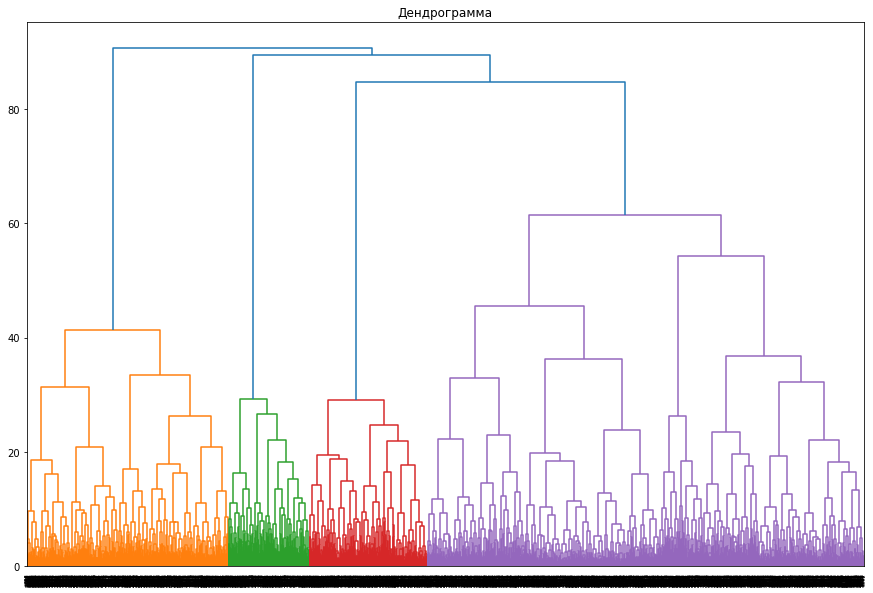

In [14]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show() 

На основании полученной дендрограммы можем выделить 4 кластера. 

Далее обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Число кластеров примем за n=5, как было указано в задании.

In [15]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
Near_Location,0.995939,0.000000,1.000000,0.996028,0.862694
Partner,0.892386,0.489247,0.217105,0.379345,0.471503
Promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
Phone,1.000000,1.000000,1.000000,1.000000,0.000000
Contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
Group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
Age,29.606091,28.679211,27.583647,30.699106,29.297927
Avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
Lifetime,4.283249,2.974910,1.922932,5.415094,3.940415


У кластера 0 самый маленький процент оттока и самый длительный текущий абонемент, что не сложно сопоставить. Еще видим, что у нулевого кластера самая большая суммарная выручка от других услуг фитнес-центра, и с большей вероятностью клиент - сотрудник компании-партнёра клуба.

Первый и второй кластер несколько похожи, наблюдается различие в степени оттока. Второй кластер более подвержен оттоку клиентов. Еще можем выделить признаки `Near_Location` и `Contract_period`, у второго кластера длительность текущего действующего абонемента ниже, чем у первого. И также второй кластер гораздо ниже по проживанию или работе в районе, где находится фитнес-центр

У третьего кластера самый большой отток клиентов, также видно, что у данного кластера самый низкий показатель посещений за последний месяц и количество посещений в целом.

Четвертый кластер имеет небольшой процент оттока, как и нулевой кластер. Стоит обратить внимание на признак `Lifetime`, у данного кластера он самый высокий, как и признак `Avg_class_frequency_current_month` -  средняя частота посещений в неделю за предыдущий месяц.


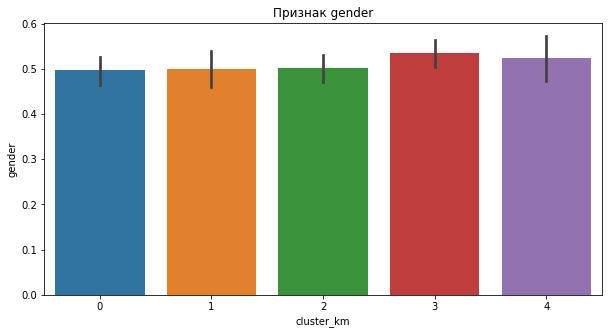

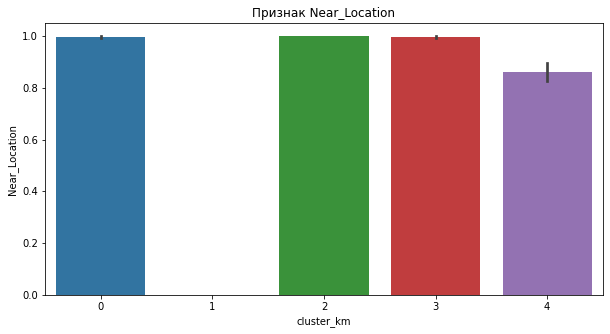

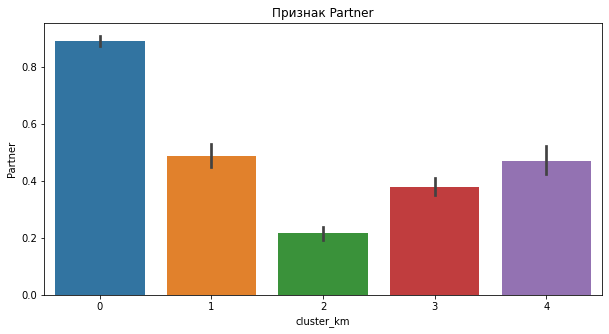

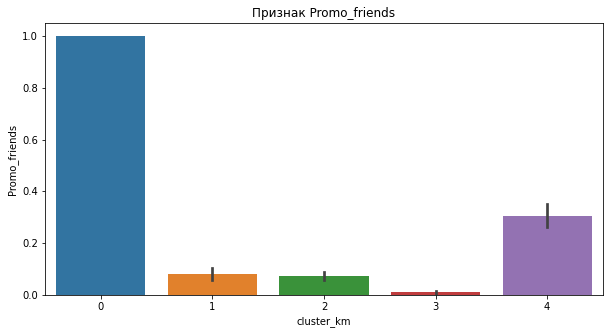

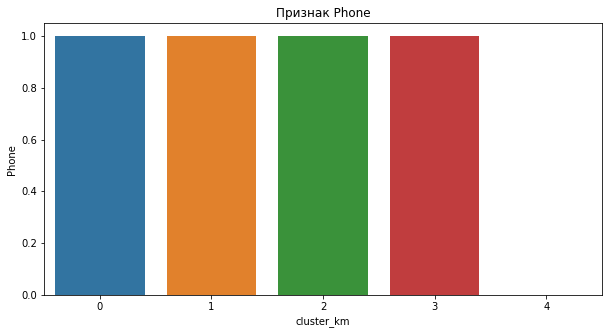

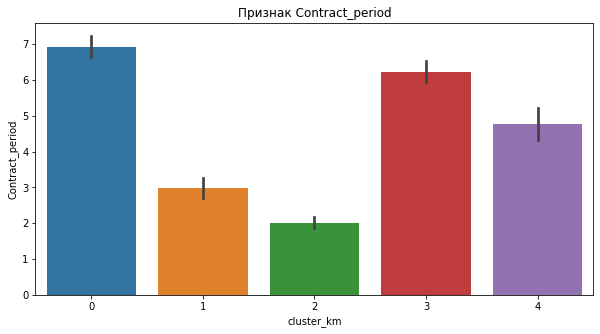

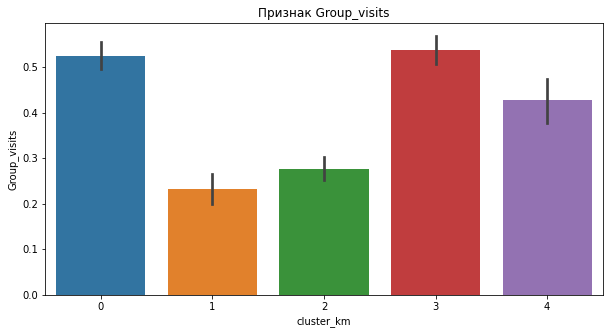

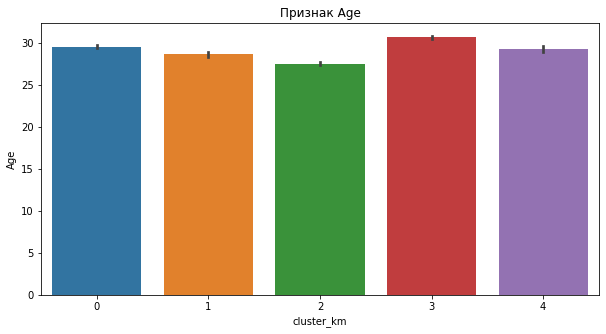

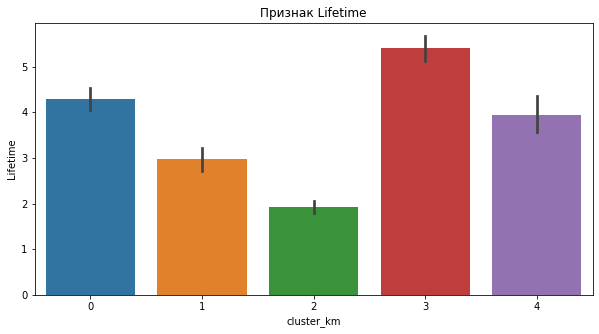

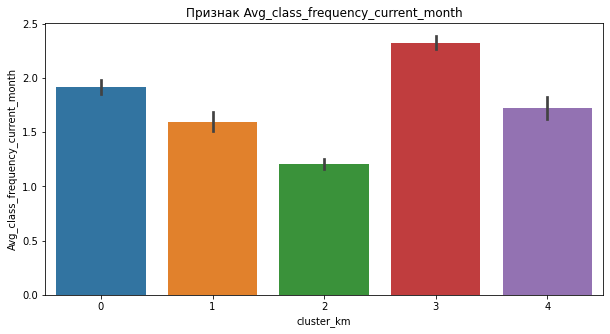

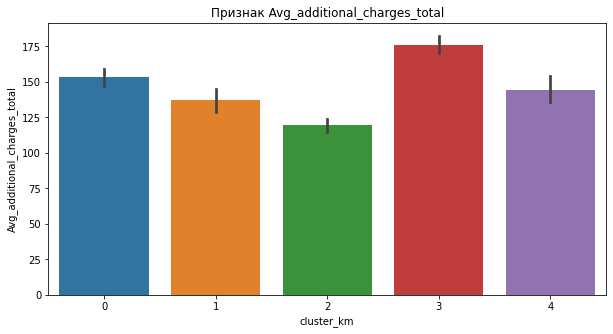

In [16]:
for t in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', \
          'Group_visits', 'Age', 'Lifetime', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']:
    plt.figure(figsize=(10, 5))
    plt.title('Признак '+t)
    plt.xlabel(j)
    sns.barplot(x ='cluster_km', y = t, data=df)
    plt.show()

По построеным графикам дополнительно можем сказать, что распределние по возрасту и полу примерно одинаковое, также примерно на одном уровне у всех кластеров признак `Avg_additional_charges_total`.

In [17]:
# Для каждого полученного кластера посчитаем долю оттока
df.groupby('cluster_km')['Churn'].mean().reset_index().sort_values(by='Churn', ascending=False)

,cluster_km,Churn
2,2,0.563910
1,1,0.403226
4,4,0.266839
0,0,0.119797
3,3,0.014896


Как мы и выявили ранее, больше всего подвержен оттоку третий кластер 51%. Далее следует второй кластер - 44%, первый кластер занимает 26% оттока, а четвертый и нулевой всего 6% и 2% оттока клиентов. 

## Вывод и рекомендации 

В ходе исследования мы спрогнозировали вероятность оттока для каждого клиента, используя модель логистической регрессии, сформировали типичные портреты клиентов, а также проанализировали основные признаки, наиболее сильно влияют на отток. Ими оказались такие признаки, как `Near_Location` — проживание или работа в районе, где находится фитнес-центр, `Contract_period` — длительность текущего действующего абонемента, `Group_visits` — факт посещения групповых занятий и `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц.

Клиенты, живущие поблизости и посещающие групповые занятия реже попадают в отток. В среднем попадающие в отток клиенты занимаются месяц, вероятнее абонемент они приобретали на пробу, и по истечении действия контракта принимали решение не продливать абонемент.

Проведя кластеризацию клиентов мы выявили 5 кластеров:

`Кластер 0:` самый маленький процент оттока и самый длительный текущий абонемент, самая большая суммарная выручка от других услуг фитнес-центра, и с большей вероятностью клиент - сотрудник компании-партнёра клуба.

`Кластер 1:` достаточно долгий Lifetime и срок до окончания текущего действующего абонемента, чаще посещают групповые занятия. 

`Кластер 2:` самый низкий показатель признака Promo_friends, более подвержен оттоку клиентов, в сравнении с первым, низкая длительность текущего действующего абонемента.

`Кластер 3:`  самый большой отток клиентов, еще у данного кластера самый низкий показатель длительности текущего абонемента, посещений за последний месяц и количество посещений в целом.

`Кластер 4:`  имеет небольшой процент оттока, как и нулевой кластер, Lifetime у данного кластера самый высокий, как и признак Avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц.

На основании проведенного анализа можно рекомендовать стараться продавать абонементы на более длительный срок, так как наблюдается тенденция оттока клиентов при небольшом сроке действия абонемента.  
Можно предлагать потенциальным клиентам приобретать абонементы на 6-12 месяцев на более выгодных условиях. 
Мы выявили, что лояльные клиенты более склонны пользоваться дополнительнымы услугами фитнес-центра, для удержания клиентов будет целесообразно ввести дополнительные скидки или бонусную систему на дополнительные услуги.

Можно посоветовать стараться привлекать клиентов из близлежащих районов, некоторые фитнес-центры практикуют дополнительные "бонусы" для жителей района, в котором располагается сам центр.  

Еще следут ввести процедуру обзвона клиентов за несколько дней до окончания действия месячного абонемента для новых клиентов и предлагать единоразовое продление на более выгодных условиях. 